# 価格の動きを直線回帰してみる。
pymc3をつかって単回帰してみる。

TODO: 約定サイズが1ドルと1万ドルを同じ１約定としてカウントすることが直感的におかしいように思う。
データサイズなどで重み付けをしたほうがよいのではないか？

In [1]:
! pip install sklearn

  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached scikit_learn-1.0-cp39-cp39-macosx_11_0_arm64.whl
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Using cached scipy-1.7.1-cp39-cp39-macosx_11_0_arm64.whl


In [2]:
import os
import datetime
import pandas as pd
from urllib import request

def get_bb_log(yyyy, mm, dd, symbol="BTCUSD"):
    """
    bybitからパラメーターに指定された日付の約定データを/tmpにダウンロードする。
    /tmpに一時保存することでキャッシュ機能を実現
    :param yyyy: 年（４桁）
    :param mm: 月
    :param dd: 日
    :param symbol: オプション：ディフォルトBTCUSD
    :return: /tmpにダウンロードしたファイル名
    """
    file_name = f'{symbol}{yyyy:04d}-{mm:02d}-{dd:02d}.csv.gz'
    tmp_file = '/tmp/'+ file_name

    if not os.path.exists(tmp_file):
        download_url = f'https://public.bybit.com/trading/{symbol}/{file_name}'
        print("download url=", download_url)
        request.urlretrieve(download_url, tmp_file)

    return tmp_file

def get_bb_df(yyyy, mm, dd):
    """
    bybitから約定データをダウンロードしpandasのDataFrameオブジェクトにする。
    :param yyyy: 年（４桁）
    :param mm: 月
    :param dd: 日
    :return: 約定データが入ったDataFrame
    """
    file = get_bb_log(yyyy, mm, dd)

    bb_df = pd.read_csv(file, index_col=0)
    bb_df.index = pd.to_datetime(bb_df.index, utc=True, unit='s')

    return bb_df


def resample_ohlcv(data, sample_time):
    """
    約定データからohlcvを作成する。
    timeに指定できるパラメータは文字列で以下のように指定する。
    15秒:'15S' / 1分: '1T' / 1時間: '1H'
    詳細はpadnasのドキュメント
    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
    :param data:　bybitの約定データの入ったDataFrame
    :param sample_time: サンプル間隔
    :return: ohlcvデータ
    """
    resample_df = data['price'].resample(sample_time).ohlc()
    resample_df['volume'] = data['size'].resample(sample_time).sum()
    return resample_df

def get_bb_df_past_days(days=10, start_day = None):
    """
    Bybitから過去から指定期間のデータをダウンロードしdfを返す。
    データが生成できていない可能性があるので２日前までの期間のデータをダウンロードする。
    :param days: データ取得期間
    :param start_day: 開始時間（指定しない場合は今日からdays+2日前）
    :return: 約定データが入ったdf
    """
    if not start_day:
        start_day = datetime.date.today() - datetime.timedelta(days=days+2)

    print('start:', start_day, "-> end:", start_day + datetime.timedelta(days=days))

    bb_df = None
    for i in range(days):
        target_day = start_day + datetime.timedelta(days=i)
        download_df = get_bb_df(target_day.year, target_day.month, target_day.day)
        if bb_df is None:
            bb_df = download_df
        else:
            bb_df = bb_df.append(download_df)

    return bb_df

In [3]:
# 過去データの取得
df = get_bb_df_past_days(1)


start: 2021-09-29 -> end: 2021-09-30


In [ ]:
import matplotlib.pyplot as plt
price = df['price']
plt.plot(price)
plt.show()

plt.hist(price, bins=50)
plt.show()

price_diff = price.diff().dropna()
plt.hist(price_diff, bins=100)
plt.show()

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression

def make_list(x):
    g = x.groupby(['side', 'price'])['homeNotional'].sum()
    return g

resample = df.resample('30S')

In [6]:
#diff_range = resample['price'].apply(lambda x: x['price'].max() - x['price'].min())
diff_range = resample['price'].apply(lambda x: x.max() - x.min())

diff_range

timestamp
2021-09-29 00:00:00+00:00    60.5
2021-09-29 00:00:30+00:00    13.0
2021-09-29 00:01:00+00:00    21.0
2021-09-29 00:01:30+00:00    42.5
2021-09-29 00:02:00+00:00    34.5
                             ... 
2021-09-29 23:57:30+00:00     0.5
2021-09-29 23:58:00+00:00     0.5
2021-09-29 23:58:30+00:00    33.5
2021-09-29 23:59:00+00:00     9.0
2021-09-29 23:59:30+00:00    37.5
Freq: 30S, Name: price, Length: 2880, dtype: float64

210.0
16.718229166666667
20.87889618725512


(array([1.09e+03, 2.30e+02, 2.49e+02, 2.10e+02, 1.83e+02, 2.14e+02,
        1.47e+02, 1.36e+02, 7.10e+01, 6.60e+01, 6.40e+01, 3.70e+01,
        2.90e+01, 2.60e+01, 2.30e+01, 1.60e+01, 1.30e+01, 1.50e+01,
        1.00e+01, 7.00e+00, 4.00e+00, 5.00e+00, 5.00e+00, 6.00e+00,
        6.00e+00, 0.00e+00, 3.00e+00, 2.00e+00, 1.00e+00, 1.00e+00,
        0.00e+00, 2.00e+00, 2.00e+00, 1.00e+00, 0.00e+00, 2.00e+00,
        1.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 1.00e+00]),
 array([  0. ,   4.2,   8.4,  12.6,  16.8,  21. ,  25.2,  29.4,  33.6,
         37.8,  42. ,  46.2,  50.4,  54.6,  58.8,  63. ,  67.2,  71.4,
         75.6,  79.8,  84. ,  88.2,  92.4,  96.6, 100.8, 105. , 109.2,
        113.4, 117.6, 121.8, 126. , 130.2, 134.4, 138.6, 142.8, 147. ,
        151.2, 155.4, 159.6, 163.8, 168. , 172.2, 176.4, 180.6, 184.8,
        189. , 193.2, 197.4, 201.6, 205.8, 210. ]),
 <BarContainer obje

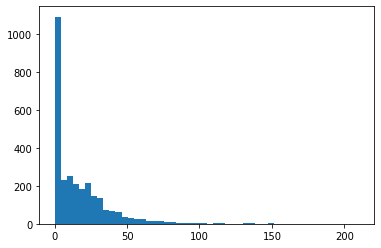

In [7]:
print(diff_range.max())
print(diff_range.mean())
print(diff_range.std())

plt.hist(diff_range.values, bins=50)

In [8]:
def make_hist(x):
    #total = x['homeNotial'].sum()
    return x.groupby('price')['homeNotional'].sum()


start= 41327.5


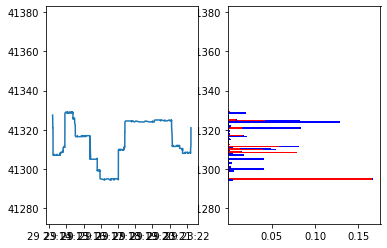

In [9]:
sample = df[8000: 9000]


def calc_prob(x):
    total = x['homeNotional'].sum()
    start_time = x.index.min()
    start_price = x.loc[start_time]['price']

    r = x.groupby(['side', 'price'])['homeNotional'].sum()/total

    return start_price, r


def hash_to_list(h, start, list_size):
    l = []
    plist = []

    for i in range(-list_size, list_size+1):
        p = start+i/2
        plist += [p]

        if p in h:
            l += [h[p]]
        else:
            l += [0]

    return l, plist

def make_prob(x, list_size=200):
    s, r = calc_prob(sample)

    print("start=", s)

    l1, plist = hash_to_list(r.xs('Buy', level='side'), s, list_size)
    l2, plist = hash_to_list(r.xs('Sell', level='side'), s, list_size)

    return s, l1, l2, plist


#array1 = hash_to_list(result.xs('Buy', level='side'), start, 200)
#array2 = hash_to_list(result.xs('Sell', level='side'), start, 200)

#plt.plot(array1, color='Red')
#plt.plot(array2, color='Blue')

s, l1, l2, plist = make_prob(sample, 100)

fig = plt.figure()

sp2 = fig.add_subplot(1, 2, 2)
sp2.barh(plist, l1, color='Red')
sp2.barh(plist, l2, color='Blue', left=l1)
ymin, ymax = plt.ylim()

sp1 = fig.add_subplot(1, 2, 1)
sp1.plot(sample['price'])
plt.ylim(ymin, ymax)


plt.show()

In [10]:


time_group = list(resample.groups.keys())
data = resample.apply(make_list)

In [11]:
data_buy= data.xs("Buy", level='side')
data_sell= data.xs("Sell", level='side')

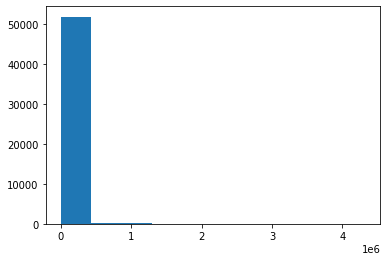

In [12]:
plt.hist(data_buy)
plt.show()

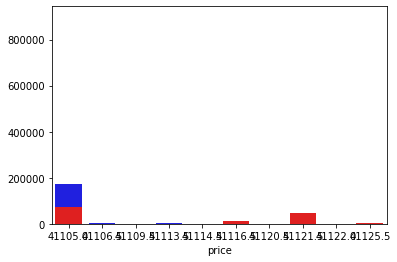

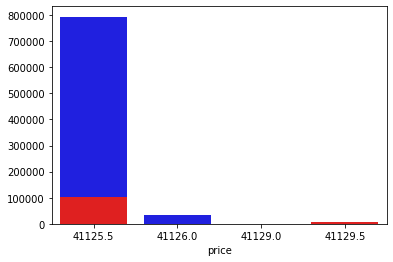

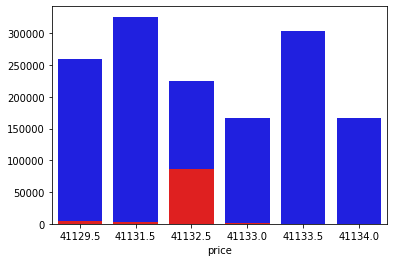

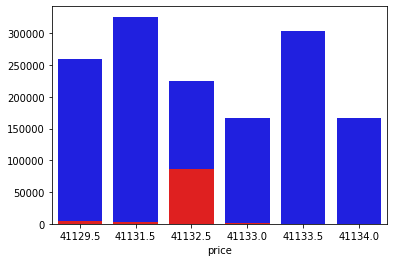

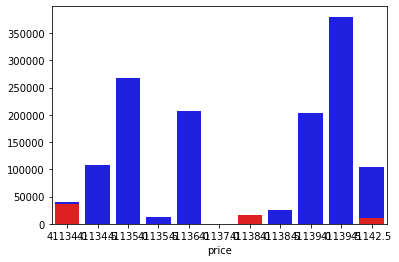

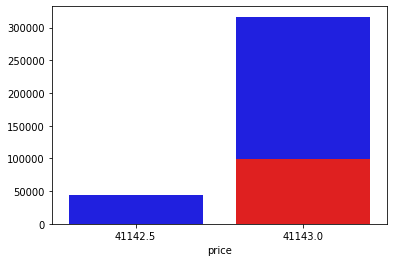

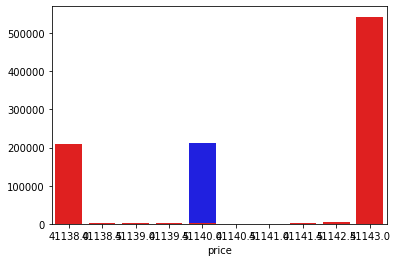

In [13]:
import seaborn as sns

shift = 10
h_buy = data_buy.xs(time_group[shift], level='timestamp')
h_sell = data_sell.xs(time_group[shift], level='timestamp')
sns.barplot(x=h_buy.index, y=h_buy.values, color='blue')
sns.barplot(x=h_sell.index, y=h_sell.values, color='red')
plt.show()


shift = 11
h_buy = data_buy.xs(time_group[shift], level='timestamp')
h_sell = data_sell.xs(time_group[shift], level='timestamp')
sns.barplot(x=h_buy.index, y=h_buy.values, color='blue')
sns.barplot(x=h_sell.index, y=h_sell.values, color='red')
plt.show()


shift = 12
h_buy = data_buy.xs(time_group[shift], level='timestamp')
h_sell = data_sell.xs(time_group[shift], level='timestamp')
sns.barplot(x=h_buy.index, y=h_buy.values, color='blue')
sns.barplot(x=h_sell.index, y=h_sell.values, color='red')
plt.show()

shift = 12
h_buy = data_buy.xs(time_group[shift], level='timestamp')
h_sell = data_sell.xs(time_group[shift], level='timestamp')
sns.barplot(x=h_buy.index, y=h_buy.values, color='blue')
sns.barplot(x=h_sell.index, y=h_sell.values, color='red')
plt.show()


shift = 13
h_buy = data_buy.xs(time_group[shift], level='timestamp')
h_sell = data_sell.xs(time_group[shift], level='timestamp')
sns.barplot(x=h_buy.index, y=h_buy.values, color='blue')
sns.barplot(x=h_sell.index, y=h_sell.values, color='red')
plt.show()


shift = 14
h_buy = data_buy.xs(time_group[shift], level='timestamp')
h_sell = data_sell.xs(time_group[shift], level='timestamp')
sns.barplot(x=h_buy.index, y=h_buy.values, color='blue')
sns.barplot(x=h_sell.index, y=h_sell.values, color='red')
plt.show()


shift = 15
h_buy = data_buy.xs(time_group[shift], level='timestamp')
h_sell = data_sell.xs(time_group[shift], level='timestamp')
sns.barplot(x=h_buy.index, y=h_buy.values, color='blue')
sns.barplot(x=h_sell.index, y=h_sell.values, color='red')
plt.show()


統計量の計算

In [14]:
def calc_stat(x):
    return x['price'].diff().std()

result = df.resample('5T').apply(calc_stat)

result



timestamp
2021-09-29 00:00:00+00:00    1.965533
2021-09-29 00:05:00+00:00    1.290281
2021-09-29 00:10:00+00:00    3.839606
2021-09-29 00:15:00+00:00    2.691046
2021-09-29 00:20:00+00:00    1.260725
                               ...   
2021-09-29 23:35:00+00:00    0.508200
2021-09-29 23:40:00+00:00    0.677225
2021-09-29 23:45:00+00:00    0.637793
2021-09-29 23:50:00+00:00    0.757937
2021-09-29 23:55:00+00:00    0.993869
Freq: 5T, Length: 288, dtype: float64

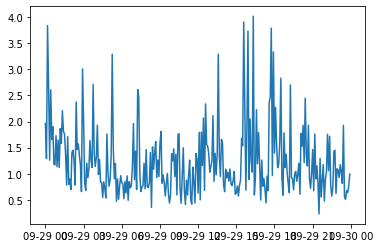

In [15]:
plt.plot(result)
plt.show()